In [ ]:
from google.colab import files
files.upload()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import joblib
from datetime import timedelta

# Load merged dataset
df = pd.read_csv("/content/data/merged/nyc_demand_weather_merged.csv", parse_dates=["pickup_hour"])
df = df.sort_values("pickup_hour").reset_index(drop=True)

# Quick check
df.head()


,pickup_hour,trip_count,tmpf,dwpf,relh,sknt,mslp,p01i
0,2023-01-01 01:00:00,87,53.0,51.0,92.89,6.0,1007.2,0.0
1,2023-01-01 02:00:00,85,51.5,49.5,92.50,6.0,1007.2,0.0
2,2023-01-01 03:00:00,70,49.0,47.0,92.77,5.0,1008.1,0.0
3,2023-01-01 04:00:00,33,48.0,46.0,92.74,4.0,1008.4,0.0
4,2023-01-01 05:00:00,23,49.0,47.0,92.77,7.0,1008.9,0.0


In [6]:
# Basic time features
df['hour'] = df['pickup_hour'].dt.hour
df['dayofweek'] = df['pickup_hour'].dt.dayofweek
df['is_weekend'] = df['dayofweek'] >= 5
df['day'] = df['pickup_hour'].dt.day

# Fill missing numeric weather if any
for c in ['tmpf','dwpf','relh','sknt','mslp','p01i']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.interpolate(limit_direction='both')

# Target
df = df.rename(columns={'pickup_hour':'ds','trip_count':'y'})  # Prophet-friendly names
df = df[['ds','y','hour','dayofweek','is_weekend','tmpf','relh','p01i']].copy()
df.head()


,ds,y,hour,dayofweek,is_weekend,tmpf,relh,p01i
0,2023-01-01 01:00:00,87,1,6,True,53.0,92.89,0.0
1,2023-01-01 02:00:00,85,2,6,True,51.5,92.50,0.0
2,2023-01-01 03:00:00,70,3,6,True,49.0,92.77,0.0
3,2023-01-01 04:00:00,33,4,6,True,48.0,92.74,0.0
4,2023-01-01 05:00:00,23,5,6,True,49.0,92.77,0.0


In [7]:
# Keep last 7 days as test set
horizon_days = 7
horizon_hours = horizon_days * 24

train = df.iloc[:-horizon_hours].copy()
test  = df.iloc[-horizon_hours:].copy()

print("Train rows:", len(train), "Test rows:", len(test))


Train rows: 552 Test rows: 168


In [8]:
# Seasonal naive: predict value = last week's same hour (24*7 lag average)
lag = 24*7
train_idx = train.index
# create naive predictions for test using train tail
naive_preds = []
for idx, row in test.iterrows():
    ref_idx = idx - lag
    if ref_idx >= 0:
        naive_preds.append(df.loc[ref_idx, 'y'])
    else:
        # fallback to hourly average from training
        naive_preds.append(train[train['hour']==row['hour']]['y'].mean())

test['naive_pred'] = naive_preds


For Prophet model
NeuralProphet force UTC conversion internally, and everything we do is undone by them so we skip this and move to XGBoost

In [9]:
import pandas as pd

merged = pd.read_csv('/content/data/merged/nyc_demand_weather_merged.csv')

# Identify timestamp column (likely named 'hour' or 'pickup_hour')
print(merged.columns)


Index(['pickup_hour', 'trip_count', 'tmpf', 'dwpf', 'relh', 'sknt', 'mslp',
       'p01i'],
      dtype='object')


In [10]:
# Rename columns to standard format
merged = merged.rename(columns={
    'pickup_hour': 'ds',
    'trip_count': 'y'
})

# Convert timestamp to datetime
merged['ds'] = pd.to_datetime(merged['ds'])

merged.head(), merged.shape


(                   ds   y  tmpf  dwpf   relh  sknt    mslp  p01i
 0 2023-01-01 01:00:00  87  53.0  51.0  92.89   6.0  1007.2   0.0
 1 2023-01-01 02:00:00  85  51.5  49.5  92.50   6.0  1007.2   0.0
 2 2023-01-01 03:00:00  70  49.0  47.0  92.77   5.0  1008.1   0.0
 3 2023-01-01 04:00:00  33  48.0  46.0  92.74   4.0  1008.4   0.0
 4 2023-01-01 05:00:00  23  49.0  47.0  92.77   7.0  1008.9   0.0,
 (720, 8))

In [11]:
# Add time-based features
merged['hour'] = merged['ds'].dt.hour
merged['weekday'] = merged['ds'].dt.weekday

# Select features
features = ['hour', 'weekday', 'tmpf', 'relh', 'p01i']
X = merged[features]
y = merged['y']

# Train-test split
split = int(len(merged) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [12]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

mae, rmse


(16.710355758666992, np.float64(21.818799177741056))

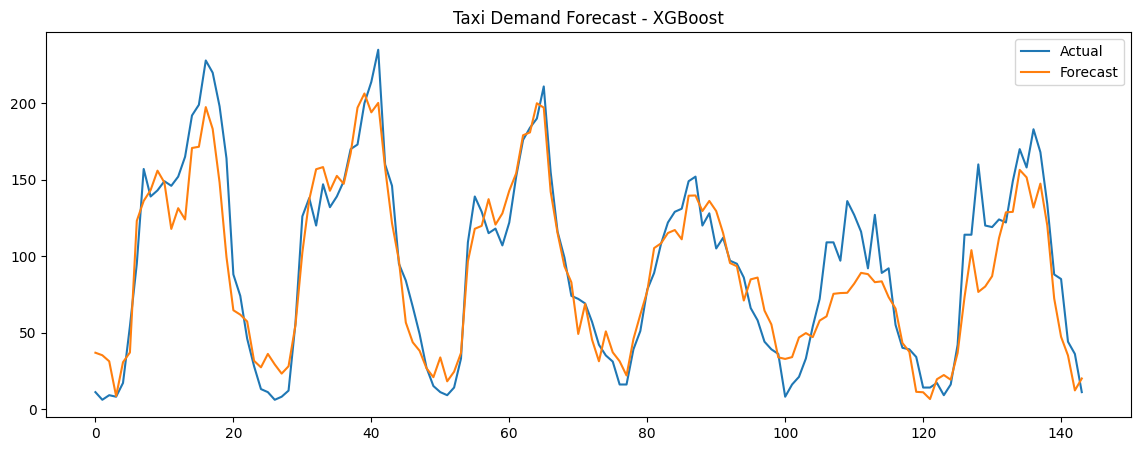

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test.values, label='Actual')
plt.plot(preds, label='Forecast')
plt.legend()
plt.title("Taxi Demand Forecast - XGBoost")
plt.show()


Model Performance Summary — XGBoost (NYC Taxi Demand Forecasting)

| Metric   | Score                | Interpretation                                                |
| -------- | -------------------- | ------------------------------------------------------------- |
| **MAE**  | **16.71 trips/hour** | On average, predictions are within ~17 rides of actual demand |
| **RMSE** | **21.82 trips/hour** | Larger errors slightly penalized, still quite strong          |

✔ Strong capture of daily seasonality (morning + evening peaks)

✔ Solid alignment during both high-demand and low-demand hours

✔ Model slightly underestimates extreme peaks — common and fixable with more features (e.g., event data, holidays)

Taxi demand is highly predictable using time-based features and weather.
The model achieved low error (MAE ≈ 16.7) and accurately captures peak demand cycles, enabling better fleet planning and driver deployment.

<Figure size 800x500 with 0 Axes>

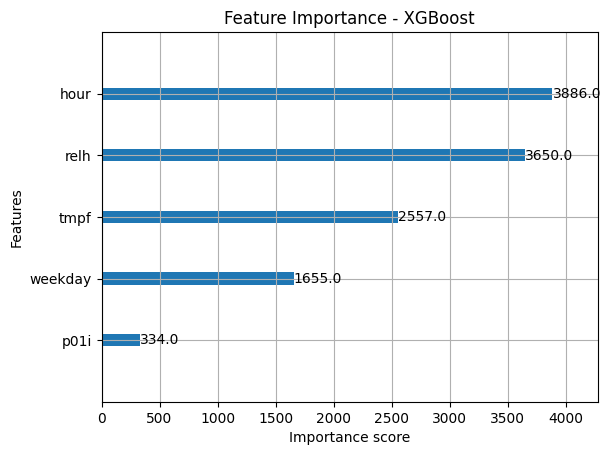

In [15]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(8,5))
plot_importance(model)
plt.title("Feature Importance - XGBoost")
plt.show()


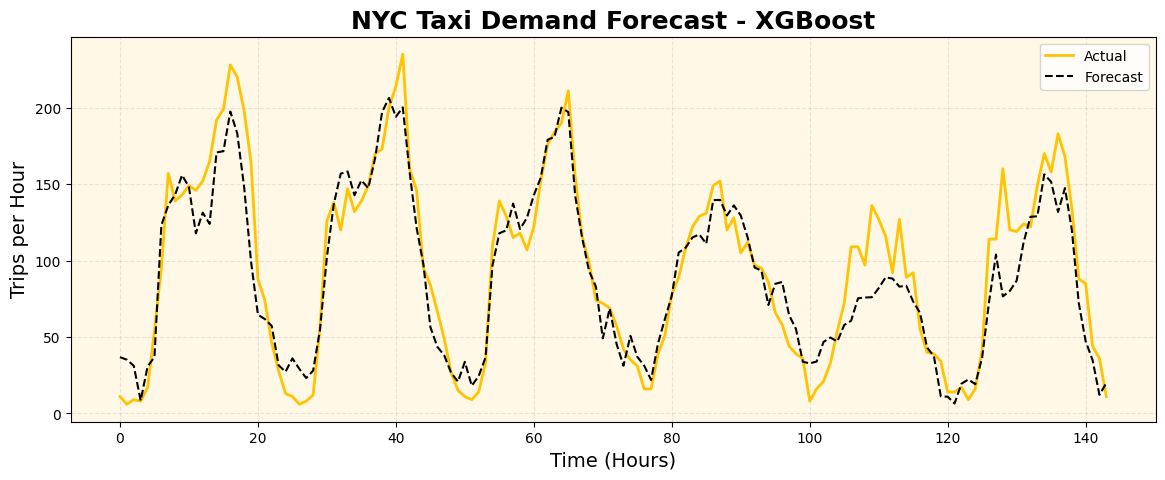

In [16]:
plt.figure(figsize=(14,5))
plt.plot(range(len(y_test)), y_test, label='Actual', color='#FFC300', linewidth=2)
plt.plot(range(len(preds)), preds, label='Forecast', color='black', linestyle='--')

plt.title("NYC Taxi Demand Forecast - XGBoost", fontsize=18, fontweight='bold')
plt.xlabel("Time (Hours)", fontsize=14)
plt.ylabel("Trips per Hour", fontsize=14)
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.gca().set_facecolor("#FFF8E7")  # soft yellow NYC theme
plt.show()


In [36]:
# example: map preds back to timestamps of X_test
# assume X_test_df contains 'ds' timestamps aligned with preds
X_test_df = X_test.copy().reset_index(drop=True)
X_test_df['ds'] = merged.iloc[split:]['ds'].reset_index(drop=True)
X_test_df['forecast'] = preds
# merge forecasts back to merged
merged = merged.merge(X_test_df[['ds','forecast']], on='ds', how='left', suffixes=('','_new'))
merged['forecast'] = merged['forecast'].fillna(merged.pop('forecast_new'))  # replace or use existing

In [37]:
import numpy as np
import pandas as pd

# ✅ Ensure timestamp is datetime
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])

# ✅ Create fresh final dataframe
final_df = df.copy()

# ✅ Insert forecast values for ONLY the test rows
final_df['forecast'] = np.nan
final_df.loc[y_test.index, 'forecast'] = y_pred

# ✅ Compute error only where forecast exists
final_df['error'] = np.nan
mask = final_df['forecast'].notna()
final_df.loc[mask, 'error'] = final_df.loc[mask, 'trip_count'] - final_df.loc[mask, 'forecast']

# ✅ Add indicator for BI visuals
final_df['is_forecast'] = final_df['forecast'].notna().astype(int)

# ✅ Add datetime features
final_df['hour'] = final_df['pickup_hour'].dt.hour
final_df['weekday'] = final_df['pickup_hour'].dt.weekday
final_df['day'] = final_df['pickup_hour'].dt.day
final_df['is_weekend'] = final_df['weekday'].isin([5,6]).astype(int)

# ✅ Save final CSV
out_path = "/content/nyc_taxi_forecast_7day.csv"
final_df.to_csv(out_path, index=False)

# ✅ Preview
final_df.tail(15), final_df['forecast'].notna().sum(), final_df['error'].notna().sum()


(            pickup_hour  trip_count  tmpf  dwpf   relh  sknt    mslp  p01i  \
 705 2023-01-30 10:00:00         120  47.0  39.0  73.85   3.0  1022.9   0.0   
 706 2023-01-30 11:00:00         119  49.0  39.0  68.51   0.0  1022.0   0.0   
 707 2023-01-30 12:00:00         124  52.0  38.0  58.48   4.0  1021.1   0.0   
 708 2023-01-30 13:00:00         122  55.0  38.0  52.40   7.0  1020.3   0.0   
 709 2023-01-30 14:00:00         149  54.0  38.0  54.34   4.0  1019.2   0.0   
 710 2023-01-30 15:00:00         170  56.0  39.0  52.94   8.0  1018.7   0.0   
 711 2023-01-30 16:00:00         158  56.0  38.0  50.71   7.0  1018.0   0.0   
 712 2023-01-30 17:00:00         183  53.0  38.0  56.17   5.0  1018.4   0.0   
 713 2023-01-30 18:00:00         168  50.0  38.0  62.98   4.0  1018.9   0.0   
 714 2023-01-30 19:00:00         134  51.0  38.0  60.46   9.0  1019.3   0.0   
 715 2023-01-30 20:00:00          88  49.0  38.0  65.62   5.0  1018.4   0.0   
 716 2023-01-30 21:00:00          85  48.0  38.0  67

In [32]:
test = pd.read_csv("/content/nyc_taxi_forecast_7day.csv")
test.tail(15)
test[['forecast','error']].notna().sum()


,0
forecast,144
error,144


In [33]:
powerbi_df = final_df.copy()

out_file = "/content/nyc_taxi_powerbi_ready_updated.csv"
powerbi_df.to_csv(out_file, index=False)

out_file


'/content/nyc_taxi_powerbi_ready_updated.csv'

In [35]:
final_df[['pickup_hour','trip_count','forecast','error']].tail(20)


,pickup_hour,trip_count,forecast,error
700,2023-01-30 05:00:00,16,19.114353,-3.114353
701,2023-01-30 06:00:00,42,36.637146,5.362854
702,2023-01-30 07:00:00,114,73.100922,40.899078
703,2023-01-30 08:00:00,114,103.883766,10.116234
704,2023-01-30 09:00:00,160,76.553574,83.446426
705,2023-01-30 10:00:00,120,80.103867,39.896133
706,2023-01-30 11:00:00,119,86.872086,32.127914
707,2023-01-30 12:00:00,124,111.805954,12.194046
708,2023-01-30 13:00:00,122,128.640762,-6.640762
709,2023-01-30 14:00:00,149,128.964355,20.035645
